In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy import interpolate
from scipy.spatial import ConvexHull

## Load Data

Load pivoted data here and create a new column for survey date.

In [198]:
# Load from csv
data = pd.read_csv('survey_data.csv')

# Create survey date column
data['Survey_Date'] = pd.to_datetime(data['Survey_ID'].str.slice(-10))

# Drop column Survey ID
data = data.drop('Survey_ID',axis=1)

## Take latest 2 surveys for each country

Since the clustering is a reflection of current situation in countries, we take only the latest 2 surveys which are usually 6 months apart.

In [199]:
data = pd.merge(data, data.groupby(['Country']).Survey_Date.nlargest(2).reset_index(), on=['Country','Survey_Date'])

## Explode outcomes

Split the outcome column into multiple rows for the further steps.

In [200]:
# Convert outcome column to list
data['outcome'] = data['outcome'].str.split('|')

outcomes = pd.Series(list(itertools.chain.from_iterable(data.outcome[~data.outcome.isna()])))
outcomes = outcomes[outcomes!='All of the above'].unique()

# If outcome is all of the above, as a preliminary step, replace it with a list of all risk factors.
data['outcome'] = data['outcome'].apply(lambda x: outcomes if type(x) is list and "All of the above" in x else x)

data_rel = data.explode('outcome', ignore_index=True)

## Distribution of risk outcomes

Create a dictionary to capture occurence counts for every risk factor for each country.

In [205]:
rcount = data_rel \
         .groupby(['Country','outcome']).size().reset_index() \
         .pivot(index='outcome',columns='Country',values=0).fillna(0).to_dict()

## Country Vectors

Convert previously created dictionary to a single vector for each country. This vector captures the presence of every risk factor. It is normalized to account for varying number of partcipants in each country.

In [207]:
countries = dict()

for k in rcount:
    countries[k] = list(rcount[k].values())

countries = pd.DataFrame(countries).transpose().reset_index()
countries.rename(columns={'index':'country'}, inplace=True)

# Normalize
countries.loc[:,np.arange(13)] = countries.loc[:,np.arange(13)].div(countries.loc[:,np.arange(13)].sum(axis=1), axis=0)*100

## Optimal Number of Clusters

This step chooses the optimal number of clusters for K-means based on Silhouette score. Since we have very little data, I expect this to choose a low number.

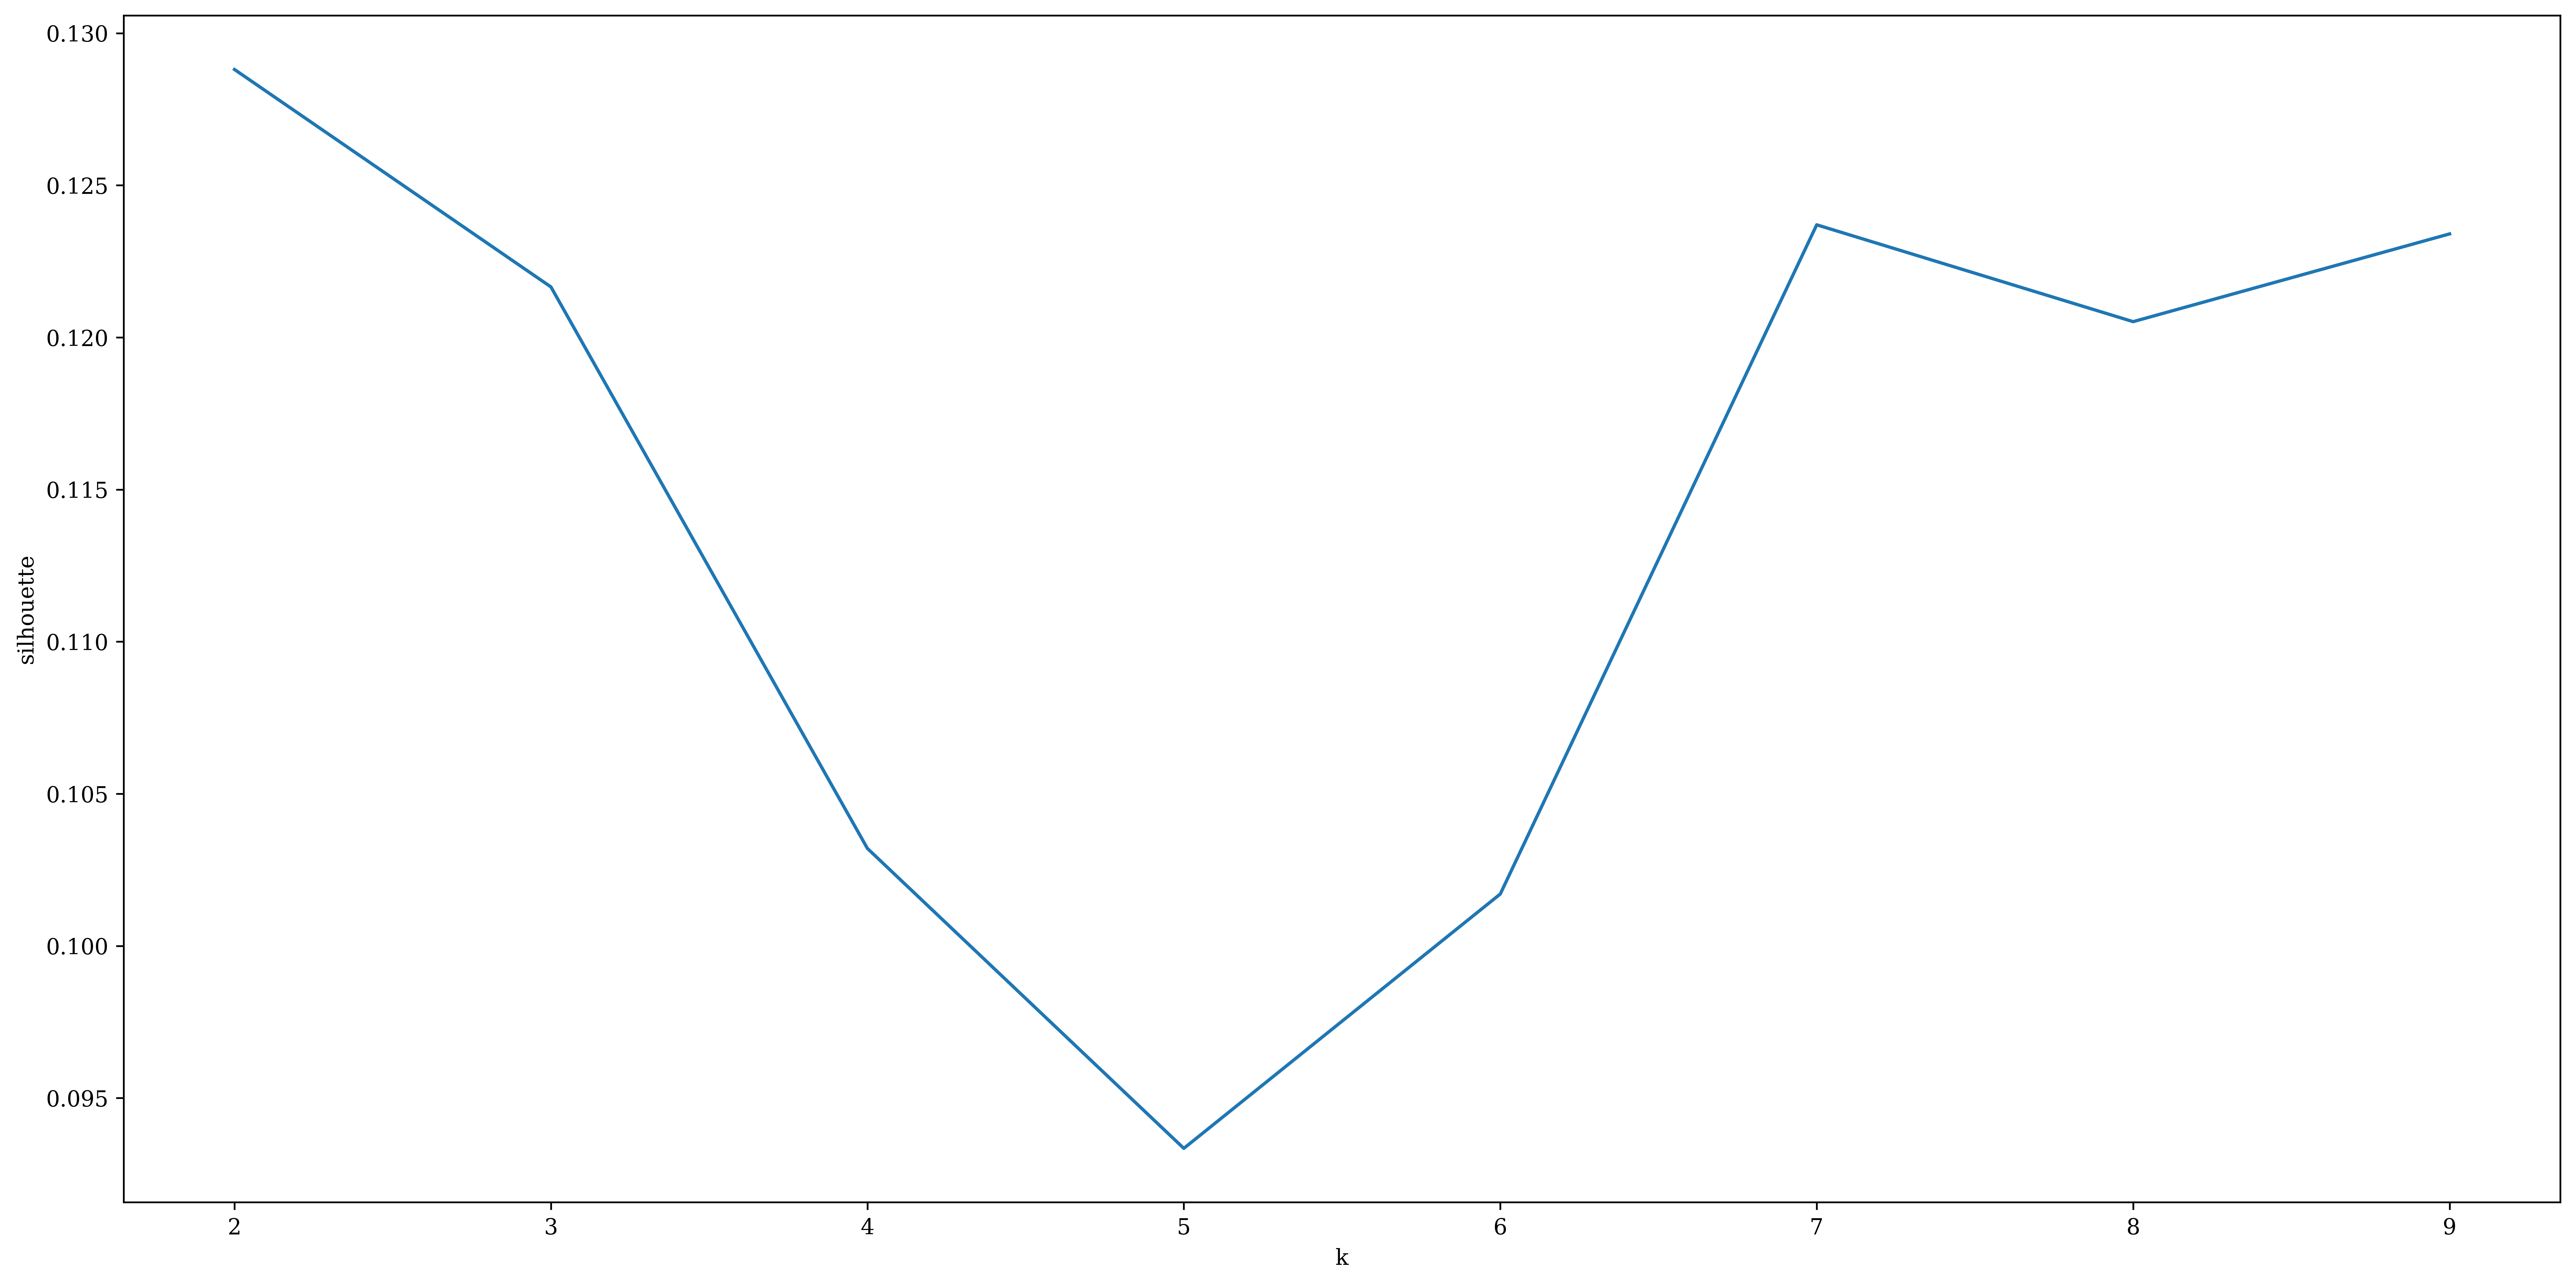

In [208]:
results = []
df = countries.drop('country',axis=1)

for k in range(2,10):
    model = KMeans(n_clusters=k, random_state=0)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    results.append((k,silhouette_avg))

results_df = pd.DataFrame(results).rename(columns={0:'k',1:'silhouette'})
sns.lineplot(data=results_df,x='k',y='silhouette');

Perform K-means based on the optimal K value that maximizes Silhoette score.

In [204]:
k = sorted(results, key=lambda x: x[1], reverse=True)[0][0]
countries['kmeans_label'] = KMeans(n_clusters=k, random_state=0).fit_predict(df)

In [190]:
pca = PCA(n_components=2, random_state=265)
pca.fit(countries.drop(['country','kmeans_label'],axis=1))
df_pca = pd.concat([countries, pd.DataFrame(pca.transform(countries.drop(['country','kmeans_label'],axis=1)), columns=["pca_dim_1", "pca_dim_2"])], axis=1)

Visualize clustering results.

In [213]:
mpl.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.size'] = 10

pal = sns.color_palette("Paired")[:len(set(df_pca['kmeans_label']))]
p1 = sns.scatterplot(x="pca_dim_1", y='pca_dim_2', hue='kmeans_label', palette = pal, data=df_pca, s=250, alpha=0.7, legend=False)

#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    pass
     #p1.text(df_pca.pca_dim_1[line], df_pca.pca_dim_2[line], df_pca.country[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.suptitle('Countries Grouped by Risk Perception', fontsize=26)


for i in df_pca.kmeans_label.unique():
    # get the convex hull
    points = df_pca[df_pca.kmeans_label == i][['pca_dim_1', 'pca_dim_2']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', c=pal[i], alpha=0.2)
    
plt.xlabel('')
plt.ylabel('')
plt.grid()
plt.show()